In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import os
import tensorflow as tf
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    ref_d = file['density'][:]
#print(ref_d)
print(ref_d.shape)

####################################################################################################################################################
def stochastic_density(d,N):
    # poisson model
    #  accurate and fast for all values of N
    # N  = number of MC samples
    assert isinstance(d,np.ndarray)
    assert isinstance(N,(int,float,np.int64,np.float64))
    assert N>0
    ds = np.random.poisson(N*d)/N
    ds*= d.sum()/ds.sum()
    return ds
#end def stochastic_density

####################################################################################################################################################

"""x_train_3d = np.zeros((1000,64,64,64))
for i in range (int(len(x_train_3d)/5)):
    for j in range (5):     
        x_train_3d[i*(j+1)] =  stochastic_density(ref_d,10000*(j+1))

print("train generated")

x_val_3d = np.zeros((500,64,64,64))
for i in range (int(len(x_val_3d)/5)):
    for j in range (5):     
        x_val_3d[i*(j+1)] =  stochastic_density(ref_d,10000*(j+1))

print("val generated")

count = 0
x_test_3d = np.zeros((100,64,64,64))
for i in range (int(len(x_test_3d)/5)):
    for j in range (5):   
        count+=1
        x_test_3d[i*(j+1)] =  stochastic_density(ref_d,10000*(j+1))

print("test generated")
print(count)


y_test_3d = np.zeros((x_test_3d.shape[0],64,64,64))
y_train_3d = np.zeros((x_train_3d.shape[0],64,64,64))
y_val_3d = np.zeros((x_val_3d.shape[0],64,64,64))
for i in range (y_test_3d.shape[0]):
    y_test_3d[i]=stochastic_density(ref_d,1000000)


for i in range (y_train_3d.shape[0]):
    y_train_3d[i]=stochastic_density(ref_d,1000000)


for i in range (y_val_3d.shape[0]):
    y_val_3d[i]=stochastic_density(ref_d,1000000)

print("here")

# Add channel dimension
x_train = x_train_3d[..., np.newaxis]
x_val   = x_val_3d[..., np.newaxis]
x_test  = x_test_3d[..., np.newaxis]

y_train = y_train_3d[..., np.newaxis]
y_val   = y_val_3d[..., np.newaxis]
y_test   = y_test_3d[..., np.newaxis]"""


# Generate noisy inputs
x_train_3d = np.array([stochastic_density(ref_d, 10000 * ((i % 5) + 1)) for i in range(1000)])
x_val_3d   = np.array([stochastic_density(ref_d, 10000 * ((i % 5) + 1)) for i in range(500)])
x_test_3d  = np.array([stochastic_density(ref_d, 10000 * ((i % 5) + 1)) for i in range(100)])

# All targets are clean versions of ref_d with very high fidelity
y_train_3d = np.array([stochastic_density(ref_d, 1e6) for _ in range(1000)])
y_val_3d   = np.array([stochastic_density(ref_d, 1e6) for _ in range(500)])
y_test_3d  = np.array([stochastic_density(ref_d, 1e6) for _ in range(100)])

# Add channel dimension
x_train = x_train_3d[..., np.newaxis]
x_val   = x_val_3d[..., np.newaxis]
x_test  = x_test_3d[..., np.newaxis]

y_train = y_train_3d[..., np.newaxis]
y_val   = y_val_3d[..., np.newaxis]
y_test  = y_test_3d[..., np.newaxis]



2025-06-24 07:42:49.767431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750776169.781317 1508313 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750776169.785584 1508313 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750776169.799253 1508313 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750776169.799264 1508313 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750776169.799266 1508313 computation_placer.cc:177] computation placer alr

(64, 64, 64)


In [5]:
import tensorflow as tf

def jensen_shannon_divergence_loss(y_true, y_pred):
    # Ensure float32 for precision
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    # Flatten to (batch_size, num_voxels)
    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    # Normalize to make probability distributions per sample
    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    # Midpoint distribution
    m = 0.5 * (y_t + y_p)

    # Per-sample KL divergences
    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)  # shape: [batch_size]
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)  # shape: [batch_size]

    # Jensen-Shannon divergence per sample
    jsd = 0.5 * (kl_true + kl_pred)  # shape: [batch_size]

    # Final scalar loss
    return tf.reduce_mean(jsd)

ERROR! Session/line number was not unique in database. History logging moved to new session 178


In [6]:
from tensorflow.keras import layers, models, optimizers

def build_generator(input_shape=(64,64,64,1)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv3D(32, 3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling3D(2)(x)
    x = layers.Conv3D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling3D(2)(x)
    x = layers.Conv3D(128, 3, padding='same', activation='relu')(x)
    x = layers.UpSampling3D(2)(x)
    x = layers.Conv3DTranspose(64, 3, padding='same', activation='relu')(x)
    x = layers.UpSampling3D(2)(x)
    x = layers.Conv3DTranspose(32, 3, padding='same', activation='relu')(x)
    outputs = layers.Conv3D(1, 3, padding='same')(x)
    return models.Model(inputs, outputs, name='Generator')

def build_discriminator(input_shape=(64,64,64,1)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv3D(32, 4, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv3D(64, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv3D(128, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, x, name='Discriminator')


In [9]:
gen = build_generator()
disc = build_discriminator()

opt_gen = optimizers.Adam(1e-4)
opt_disc = optimizers.Adam(1e-4)
bce = tf.keras.losses.BinaryCrossentropy()

# Your Jensen-Shannon loss (already defined)
# jensen_shannon_divergence_loss(y_true, y_pred)

batch_size = 20
epochs = 10
steps_per_epoch = x_train.shape[0] // batch_size


In [19]:
for epoch in range(epochs):
    for step in range(steps_per_epoch):
        # === Sample batch ===
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        x_batch = x_train[idx]       # Noisy input
        y_batch = y_train[idx]       # Clean reference

        # === Generate denoised output ===
        def renormalize_sum_to_eight(x):
            total = tf.reduce_sum(x, axis=[1,2,3,4], keepdims=True) + 1e-8
            return x / total * 8.0
        y_fake = gen(x_batch, training=True)
        y_fake = tf.nn.relu(y_fake)
        y_fake = renormalize_sum_to_eight(y_fake)

        # === Train Discriminator ===
        with tf.GradientTape() as tape:
            pred_real = disc(y_batch)
            pred_fake = disc(y_fake)
            d_loss = bce(tf.ones_like(pred_real), pred_real) + bce(tf.zeros_like(pred_fake), pred_fake)
        grads = tape.gradient(d_loss, disc.trainable_weights)
        opt_disc.apply_gradients(zip(grads, disc.trainable_weights))

        # === Train Generator ===
        with tf.GradientTape() as tape:
            λ_adv = 0.5
            λ_js  = 1.0
            λ_l1  = 10.0


            y_fake = gen(x_batch, training=True)
            pred_fake = disc(y_fake)
            adv_loss = bce(tf.ones_like(pred_fake), pred_fake)
            js_loss = jensen_shannon_divergence_loss(y_batch, y_fake)
            l1_loss = tf.reduce_mean(tf.abs(y_batch - y_fake))
            g_loss = λ_adv * adv_loss + λ_js * js_loss + λ_l1 * l1_loss

        grads = tape.gradient(g_loss, gen.trainable_weights)
        opt_gen.apply_gradients(zip(grads, gen.trainable_weights))

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss.numpy():.4f} | G Loss: {g_loss.numpy():.4f}")


Epoch 1/10 | D Loss: 0.0001 | G Loss: 5.6572
Epoch 2/10 | D Loss: 0.0001 | G Loss: 5.6710
Epoch 3/10 | D Loss: 0.0001 | G Loss: 5.6857
Epoch 4/10 | D Loss: 0.0001 | G Loss: 5.6998
Epoch 5/10 | D Loss: 0.0001 | G Loss: 5.7146
Epoch 6/10 | D Loss: 0.0001 | G Loss: 5.7290
Epoch 7/10 | D Loss: 0.0001 | G Loss: 5.7450
Epoch 8/10 | D Loss: 0.0001 | G Loss: 5.7606
Epoch 9/10 | D Loss: 0.0001 | G Loss: 5.7760
Epoch 10/10 | D Loss: 0.0001 | G Loss: 5.7918


In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np

# === Generator ===
def build_generator(input_shape=(64,64,64,1)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv3D(32, 3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling3D(2)(x)
    x = layers.Conv3D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling3D(2)(x)
    x = layers.Conv3D(128, 3, padding='same', activation='relu')(x)
    x = layers.UpSampling3D(2)(x)
    x = layers.Conv3DTranspose(64, 3, padding='same', activation='relu')(x)
    x = layers.UpSampling3D(2)(x)
    x = layers.Conv3DTranspose(32, 3, padding='same', activation='relu')(x)
    outputs = layers.Conv3D(1, 3, padding='same')(x)  # No activation
    return models.Model(inputs, outputs, name='Generator')

# === Discriminator ===
def build_discriminator(input_shape=(64,64,64,1)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv3D(32, 4, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv3D(64, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv3D(128, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, x, name='Discriminator')

# === Losses ===
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.reshape(tf.cast(y_true, tf.float32), [tf.shape(y_true)[0], -1])
    y_p = tf.reshape(tf.cast(y_pred, tf.float32), [tf.shape(y_pred)[0], -1])
    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8
    m = 0.5 * (y_t + y_p)
    kl_t = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8)/(m + 1e-8)), axis=1)
    kl_p = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8)/(m + 1e-8)), axis=1)
    jsd = 0.5 * (kl_t + kl_p)
    return tf.reduce_mean(jsd)

def fft_loss(y_true, y_pred):
    y_true_fft = tf.signal.fft3d(tf.cast(y_true, tf.complex64))
    y_pred_fft = tf.signal.fft3d(tf.cast(y_pred, tf.complex64))
    return tf.reduce_mean(tf.abs(tf.abs(y_true_fft) - tf.abs(y_pred_fft)))

# === Renormalization ===
def renormalize_sum_to_eight(x):
    total = tf.reduce_sum(x, axis=[1,2,3,4], keepdims=True) + 1e-8
    return x / total * 8.0

# === Build models ===
gen = build_generator()
disc = build_discriminator()

opt_gen = optimizers.Adam(1e-4)
opt_disc = optimizers.Adam(1e-4)
bce = tf.keras.losses.BinaryCrossentropy()

# === Training ===
batch_size = 20
epochs = 10
steps_per_epoch = x_train.shape[0] // batch_size

for epoch in range(epochs):
    for step in range(steps_per_epoch):
        # Sample batch
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        x_batch = x_train[idx]
        y_batch = y_train[idx]

        # Generate output for discriminator
        y_fake = gen(x_batch, training=True)
        y_fake = tf.nn.relu(y_fake) + 1e-4  # Encourage positivity
        y_fake = renormalize_sum_to_eight(y_fake)  # Ensure integral is 8

        # Train discriminator
        with tf.GradientTape() as tape:
            pred_real = disc(y_batch)
            pred_fake = disc(y_fake)
            d_loss = bce(tf.ones_like(pred_real), pred_real) + bce(tf.zeros_like(pred_fake), pred_fake)
        grads = tape.gradient(d_loss, disc.trainable_weights)
        opt_disc.apply_gradients(zip(grads, disc.trainable_weights))

        # Train generator
        with tf.GradientTape() as tape:
            y_fake = gen(x_batch, training=True)
            y_fake = tf.nn.relu(y_fake) + 1e-4
            y_fake = renormalize_sum_to_eight(y_fake)

            pred_fake = disc(y_fake)
            adv_loss = bce(tf.ones_like(pred_fake), pred_fake)
            js_loss = jensen_shannon_divergence_loss(y_batch, y_fake)
            struct_loss = fft_loss(y_batch, y_fake)

            λ_adv = 0.5
            λ_js  = 1.0
            λ_struct = 5.0
            g_loss = λ_adv * adv_loss + λ_js * js_loss + λ_struct * struct_loss

        grads = tape.gradient(g_loss, gen.trainable_weights)
        opt_gen.apply_gradients(zip(grads, gen.trainable_weights))

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss.numpy():.4f} | G Loss: {g_loss.numpy():.4f}")


Epoch 1/10 | D Loss: 1.3815 | G Loss: 0.4270
Epoch 2/10 | D Loss: 1.0902 | G Loss: 0.5061
Epoch 3/10 | D Loss: 0.6661 | G Loss: 0.8861
Epoch 4/10 | D Loss: 0.8245 | G Loss: 0.7134
Epoch 5/10 | D Loss: 2.9467 | G Loss: 0.4191
Epoch 6/10 | D Loss: 1.7881 | G Loss: 0.4561
Epoch 7/10 | D Loss: 1.5320 | G Loss: 0.3926
Epoch 8/10 | D Loss: 1.4685 | G Loss: 0.3728
Epoch 9/10 | D Loss: 1.4371 | G Loss: 0.3660
Epoch 10/10 | D Loss: 1.4235 | G Loss: 0.3609


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step


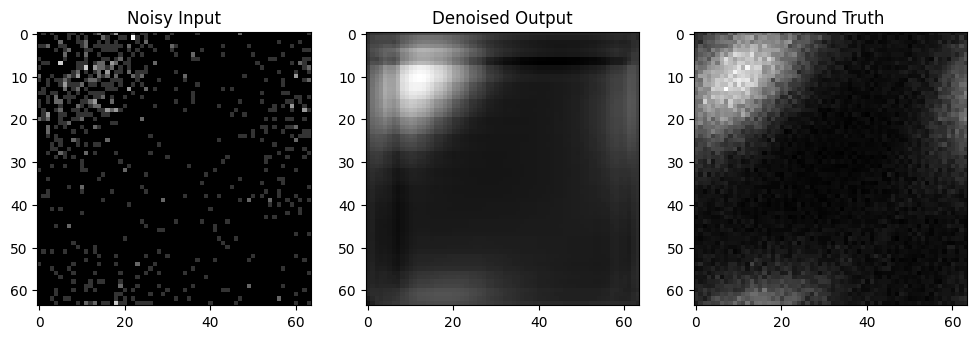

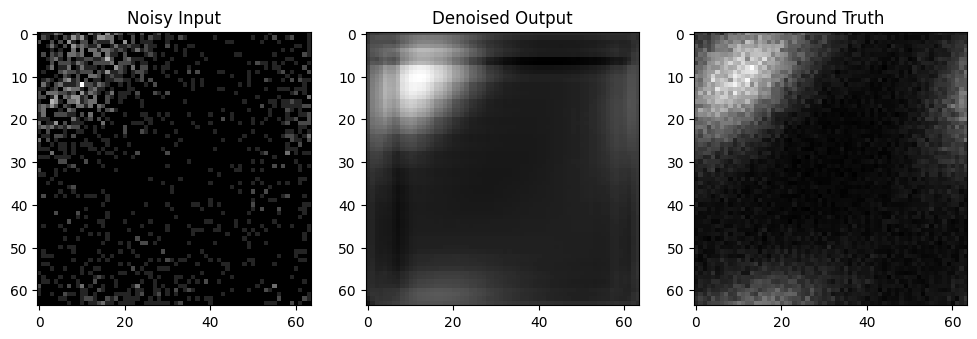

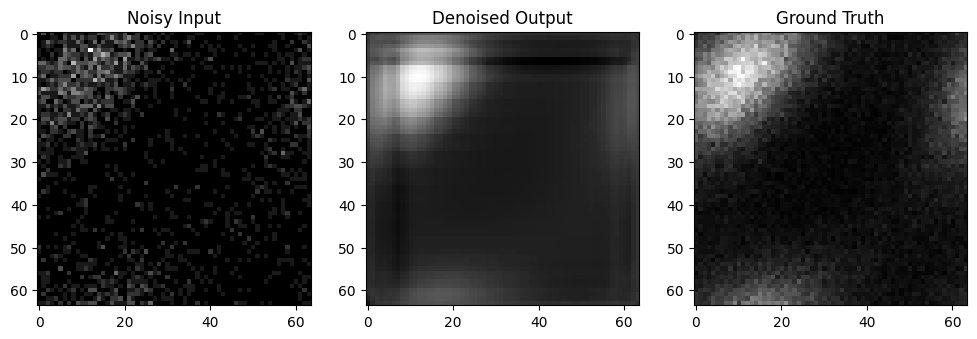

In [26]:
x_out = gen.predict(x_test)

import matplotlib.pyplot as plt

for i in range(3):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(x_test[i, :, :, 32, 0], cmap='gray')
    plt.title("Noisy Input")

    plt.subplot(1, 3, 2)
    plt.imshow(x_out[i, :, :, 32, 0], cmap='gray')
    plt.title("Denoised Output")

    plt.subplot(1, 3, 3)
    plt.imshow(y_test[i, :, :, 32, 0], cmap='gray')
    plt.title("Ground Truth")
    plt.show()
